In [176]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load data

In [206]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [207]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [208]:
# It's a binary classification problem 
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([171, 379]))


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [211]:
def cross_validation(x_train, y_train, k=5):
    # set the index as long as the training data and shuffle
    # then split it into k groups
    indexes = np.arange(len(x_train))
    np.random.shuffle(indexes)
    folds = np.array_split(indexes, k)
    kfold = []
    for i in range(len(folds)):
        kfold.append([np.concatenate(folds[:i] + folds[i+1:]), folds[i]])
    return np.array(kfold)

In [213]:
kfold_data = cross_validation(x_train, y_train, k=10)
for i in range(len(kfold_data)):
    print(f'fold {i} training fold: ', np.sort(kfold_data[i][0]))
    print(f'fold {i} validation fold: ', np.sort(kfold_data[i][1]))
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

fold 0 training fold:  [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  33  34  35  36  37  38  39
  40  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57  58  59
  61  62  63  64  65  66  67  68  69  71  73  74  75  77  78  79  80  81
  82  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 101
 102 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 124 125 126 127 128 129 130 131 134 135 136 137 138 139 140 141
 142 143 144 145 147 148 149 150 152 153 154 155 156 157 158 159 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 180 181 182
 184 185 186 187 188 189 190 191 193 194 195 196 197 198 199 200 202 203
 204 206 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 223
 225 226 227 228 229 230 231 232 233 234 236 237 238 239 240 241 242 243
 244 245 246 247 249 250 251 252 253 254 255 256 258 259 260 261 262 263
 264 266 267 268 270 271 272

## example

In [183]:
from sklearn.model_selection import KFold

def kfold_example():
    X = np.arange(20)
    kf = KFold(n_splits=5, shuffle=True)
    kfold_data= []
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
        kfold_data.append([train_index, val_index])
    assert len(kfold_data) == 5 # should contain 5 fold of data
    assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
    assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [184]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
clfs = [SVC(C=C, kernel='rbf', gamma=gamma) for C in Cs for gamma in gammas]

In [185]:
# grid search by looping all combinations C and gamma
# then use cross validation to get the model that gives
# us the maximum score
def grid_search(data, clfs):
    average_scores = []
    for clf in clfs:
        scores = []
        for fold in data:
            model = clf.fit(x_train[fold[0]], y_train[fold[0]])
            score = model.score(x_train[fold[1]], y_train[fold[1]])
            scores.append(score)
        average_scores.append(np.mean([x for x in scores]))
    best_index = average_scores.index(max(average_scores))
    best_model = clfs[best_index]
    return average_scores, best_model

In [186]:
average_scores, best_model = grid_search(kfold_data, clfs)
best_model

SVC(C=10, gamma=0.001)

## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

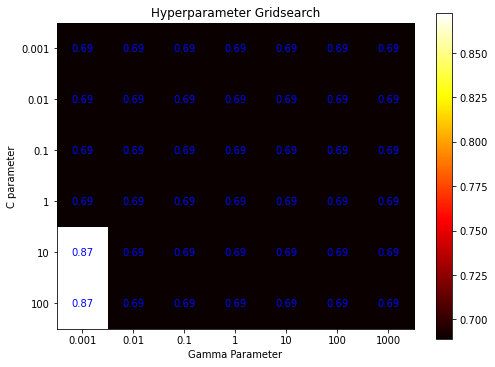

In [187]:
# draw the heatmap by all combinations of C, gamma, and average scores
def heatmap(scores, x, y):
    scores_matrix = np.reshape(scores, (len(y), len(x)))
    plt.figure(figsize=(8, 6))
    plt.imshow(scores_matrix, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('Gamma Parameter')
    plt.ylabel('C parameter')
    plt.colorbar()
    plt.xticks(np.arange(len(x)), x)
    plt.yticks(np.arange(len(y)), y)
    plt.title('Hyperparameter Gridsearch')
    for i in range(len(x)):
        for j in range(len(y)):
            plt.text(i, j, '%.2f' % scores_matrix[j][i], ha='center', va='center', color='blue')
    plt.show()

heatmap(average_scores, gammas, Cs)

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **Your accuracy should over 0.85**

In [188]:
best_model.fit(x_train, y_train)

SVC(C=10, gamma=0.001)

In [189]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of the model you have implemented in HW1 with the SVM

### HW1

In [190]:
train_df = pd.read_csv("../hw1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1, 1)
y_train = train_df['y_train'].to_numpy().reshape(-1, 1)

test_df = pd.read_csv("../hw1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1, 1)
y_test = test_df['y_test'].to_numpy().reshape(-1, 1)

### cross validation and kfold

In [191]:
kfold_data = cross_validation(x_train, y_train, k=10)
regs = [SVR(C=C, kernel='rbf', gamma=gamma) for C in Cs for gamma in gammas]

### Start training

In [192]:
average_scores = []
for reg in regs:
    scores = []
    for fold in kfold_data:
        model = reg.fit(x_train[fold[0]], y_train[fold[0]])
        score = model.score(x_train[fold[1]], y_train[fold[1]])
        scores.append(score)
    average_scores.append(np.mean([x for x in scores]))
best_index = average_scores.index(max(average_scores))
best_model = regs[best_index]
print(best_model)

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

SVR(C=100, gamma=0.001)


### Display heatmap

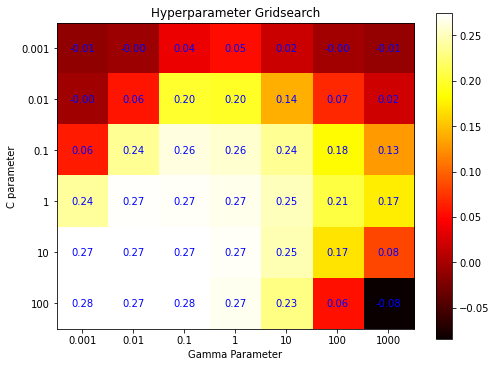

In [193]:
heatmap(average_scores, gammas, Cs)

### Testing the best model

In [194]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

/home/zeze/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Calculate mean-square-error

In [195]:
mse = 0
for t, p in zip(y_test, y_pred):
    mse += (t[0] - p)**2
mse /= len(y_test)

In [196]:
print("Square error of Linear regression: ", 0.4933820379029851)
print("Square error of SVM regresssion model: ", mse)

Square error of Linear regression:  0.4933820379029851
Square error of SVM regresssion model:  0.4928989654564852
